In [44]:
# For Kaggle

# Standard Libraries
import sys
import os
import collections
import random

# Data Science Libraries
import pandas as pd
import numpy as np

# # Configure Visualization
# %matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from utils import inspect_columns

# Statistics Libraries
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.graphics.api as smg

# ML Libraries
import sklearn
import lightgbm
import xgboost as xgb
from sklearn.pipeline import Pipeline 
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score, cross_validate, GridSearchCV
from sklearn.metrics import mean_absolute_error, make_scorer
from mlxtend.evaluate.time_series import (
    GroupTimeSeriesSplit,
    plot_splits,
    print_cv_info,
    print_split_info,
)

# Project Libraries
# import optiver2023

In [45]:
input_path = './train.csv'
df = pd.read_csv(input_path)
df

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,NaN,NaN,0.999812,60651.50,1.000026,8493.03,1.000000,-3.029704,0,0_0_0
1,1,0,0,166603.91,-1,0.999896,1642214.25,NaN,NaN,0.999896,3233.04,1.000660,20605.09,1.000000,-5.519986,0,0_0_1
2,2,0,0,302879.87,-1,0.999561,1819368.03,NaN,NaN,0.999403,37956.00,1.000298,18995.00,1.000000,-8.389950,0,0_0_2
3,3,0,0,11917682.27,-1,1.000171,18389745.62,NaN,NaN,0.999999,2324.90,1.000214,479032.40,1.000000,-4.010200,0,0_0_3
4,4,0,0,447549.96,-1,0.999532,17860614.95,NaN,NaN,0.999394,16485.54,1.000016,434.10,1.000000,-7.349849,0,0_0_4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5237975,195,480,540,2440722.89,-1,1.000317,28280361.74,0.999734,0.999734,1.000317,32257.04,1.000434,319862.40,1.000328,2.310276,26454,480_540_195
5237976,196,480,540,349510.47,-1,1.000643,9187699.11,1.000129,1.000386,1.000643,205108.40,1.000900,93393.07,1.000819,-8.220077,26454,480_540_196
5237977,197,480,540,0.00,0,0.995789,12725436.10,0.995789,0.995789,0.995789,16790.66,0.995883,180038.32,0.995797,1.169443,26454,480_540_197
5237978,198,480,540,1000898.84,1,0.999210,94773271.05,0.999210,0.999210,0.998970,125631.72,0.999210,669893.00,0.999008,-1.540184,26454,480_540_198


## Exploratory Data Analysis

In [46]:
inspect_columns(df)

,len,unique,cardinality,null_cnt,null_pct,1st_row,random_row,last_row,dtype
stock_id,5237980,False,200,0,0.000000,0,96,199,int64
date_id,5237980,False,481,0,0.000000,0,207,480,int64
seconds_in_bucket,5237980,False,55,0,0.000000,0,150,540,int64
imbalance_size,5237980,False,2971863,220,0.004200,3180602.69,13634891.2,1884285.71,float64
imbalance_buy_sell_flag,5237980,False,3,0,0.000000,1,1,-1,int64
reference_price,5237980,False,28741,220,0.004200,0.999812,1.00424,1.002129,float64
matched_size,5237980,False,2948862,220,0.004200,13380276.64,56859444.27,24073677.32,float64
far_price,5237980,False,95739,2894342,55.256836,NaN,NaN,1.000859,float64
near_price,5237980,False,84625,2857180,54.547364,NaN,NaN,1.001494,float64
bid_price,5237980,False,28313,220,0.004200,0.999812,1.004075,1.002129,float64


### Understand Data

#### 1. seconds_in_bucket

The results shows that we have first 9min data (10s each), and the goal or the target is the data from last 1min

In [47]:
df['seconds_in_bucket'].value_counts().sort_index()

seconds_in_bucket
0      95236
10     95236
20     95236
30     95236
40     95236
50     95236
60     95236
70     95236
80     95236
90     95236
100    95236
110    95236
120    95236
130    95236
140    95236
150    95236
160    95236
170    95236
180    95236
190    95236
200    95236
210    95236
220    95236
230    95236
240    95236
250    95236
260    95236
270    95236
280    95236
290    95236
300    95236
310    95236
320    95236
330    95236
340    95236
350    95236
360    95236
370    95236
380    95236
390    95236
400    95236
410    95236
420    95236
430    95236
440    95236
450    95236
460    95236
470    95236
480    95236
490    95236
500    95236
510    95236
520    95236
530    95236
540    95236
Name: count, dtype: int64

#### 2. Stock_id & date_id

No missing values in all rows.

200 stocks * 481 days * 55 = 5291000 (=5237980 + 53020)

which makes sense because not stock_id exist in every time bucket

In [48]:
(df.groupby(['stock_id', 'date_id'])['seconds_in_bucket'].count() == 55).all()

True

Thus, no stock at some date has some seconds loss, and 55 steps, which is good.

In [49]:
(
    df.groupby('stock_id')
    ['date_id']
    .count().reset_index()
    .query('date_id != 26455')
    .apply(lambda x: (26455-x.loc['date_id'])//55, axis=1).reset_index()
    .rename({"index": 'stock_id', 0: "miss_days"}, axis=1)
    .sort_values(by='miss_days')
)

,stock_id,miss_days
1,73,1
4,99,1
2,78,4
0,69,37
9,156,37
7,150,59
8,153,70
10,199,88
3,79,181
6,135,191


#### 3. time_id & row_id

row_id is a unique_identifier of this data


481 * 55 = 26455, which makes sense. Thus, time_id = 55 * date_id + seconds_in_bucket//10

In [50]:
any(df.eval('time_id - 55*date_id - seconds_in_bucket/10'))

False

In [51]:
df.query('date_id==1').head()

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
10505,0,1,0,1870169.40,1,0.999923,5132566.71,NaN,NaN,0.999601,9302.00,1.000998,23287.50,1.0,-14.089942,55,1_0_0
10506,1,1,0,648832.14,-1,0.999710,2714505.33,NaN,NaN,0.999884,517.35,1.000232,1035.06,1.0,7.330179,55,1_0_1
10507,2,1,0,867091.90,1,1.000126,4229483.69,NaN,NaN,0.999645,23209.08,1.000286,18729.00,1.0,-2.710223,55,1_0_2
10508,3,1,0,24475003.80,1,0.999356,9177225.49,NaN,NaN,0.999571,125960.80,1.000002,465.00,1.0,-6.669760,55,1_0_3
10509,4,1,0,216002.20,-1,0.999875,11183560.41,NaN,NaN,0.999875,711.85,1.000648,3704.48,1.0,0.929832,55,1_0_4


#### 4. reference price, far price, near price [publish at the start of 5min]


<Axes: xlabel='seconds_in_bucket'>

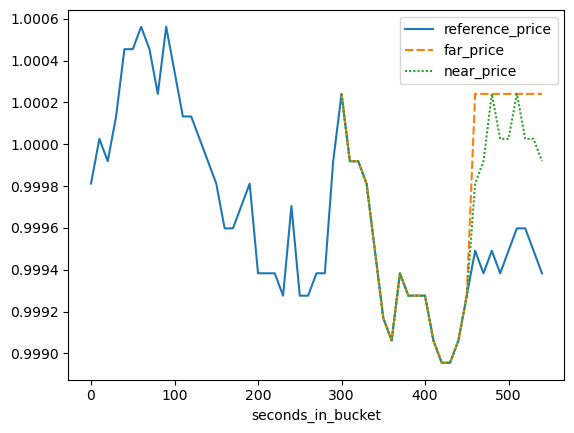

In [52]:
(
    df.query('stock_id == 0 and date_id == 0')
    .set_index('seconds_in_bucket')
    [['reference_price', 'far_price','near_price']]
    .pipe(
        sns.lineplot
    )
)

imbalance_size, imbalance_buy_sell_flag, matched_size, bid_size, ask_size

<Axes: xlabel='seconds_in_bucket', ylabel='imbalance_buy_sell_flag'>

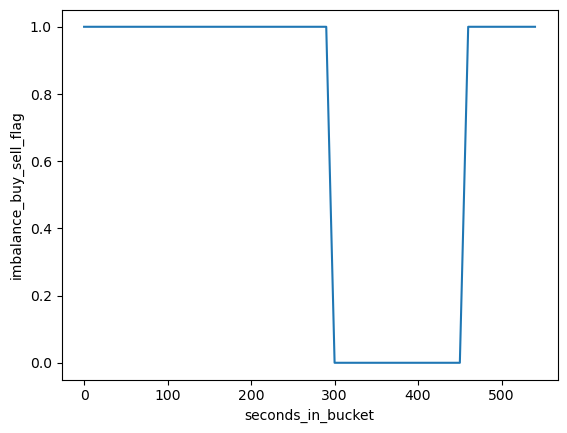

In [53]:
(
    df.query('stock_id == 0 and date_id == 0')
    .set_index('seconds_in_bucket')
    ['imbalance_buy_sell_flag']
    .pipe(sns.lineplot)
)

<Axes: xlabel='seconds_in_bucket'>

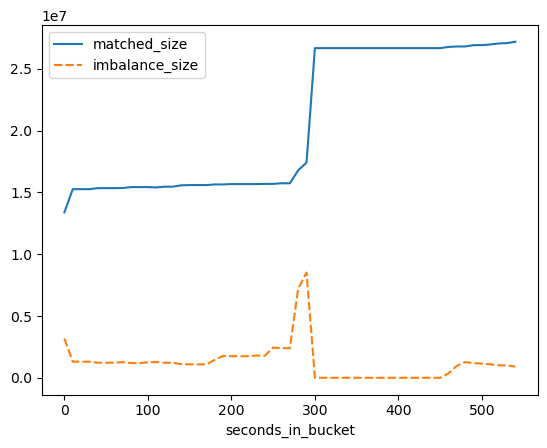

In [54]:
(
    df.query('stock_id == 0 and date_id == 0')
    .set_index('seconds_in_bucket')
    [['matched_size', 'imbalance_size']]
    .pipe(sns.lineplot)
)

After auction book published, the matched size has apparent convergene to match 

ask_size and bid_size is the size at the most competitive level, not total bid/ask size at all price levels

In [55]:
df[df['far_price'].isnull() & df['near_price'].notnull()]

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
5763,33,0,300,3092376.98,-1,0.997339,8978868.85,NaN,0.958708,0.996829,16547.96,0.997922,18345.94,0.997348,6.040335,30,0_300_33
5803,74,0,300,10011877.82,-1,0.998111,25349282.16,NaN,0.939632,0.998111,698.76,0.999197,6295.68,0.998220,-12.279749,30,0_300_74
5816,89,0,300,3752394.06,-1,0.998701,8351193.72,NaN,0.951207,0.997631,30906.00,0.999030,3034.25,0.998905,-12.260079,30,0_300_89
5818,91,0,300,9722538.89,1,1.001756,19001042.87,NaN,1.030012,1.001926,10030.68,1.002605,295.22,1.002586,-17.600060,30,0_300_91
5954,33,0,310,2974526.41,-1,0.996829,9096719.42,NaN,0.962498,0.996829,52242.32,0.997047,70310.06,0.996922,8.230209,31,0_310_33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5236124,144,480,450,9083704.04,-1,0.998723,27319450.26,NaN,0.900102,0.998723,8798.61,0.998845,90052.80,0.998734,2.839565,26445,480_450_144
5236151,171,480,450,7389482.22,-1,0.999281,22202291.97,NaN,0.950294,0.999371,13216.00,0.999460,22514.01,0.999404,0.070333,26445,480_450_171
5236167,187,480,450,8083304.67,1,1.000180,29493925.41,NaN,1.038808,1.000026,30150.72,1.000180,11178.28,1.000138,-4.169941,26445,480_450_187
5236240,60,480,460,29976877.98,-1,0.990839,75750325.85,NaN,0.949708,0.990771,44953.10,0.990839,40315.56,0.990807,-2.679825,26446,480_460_60


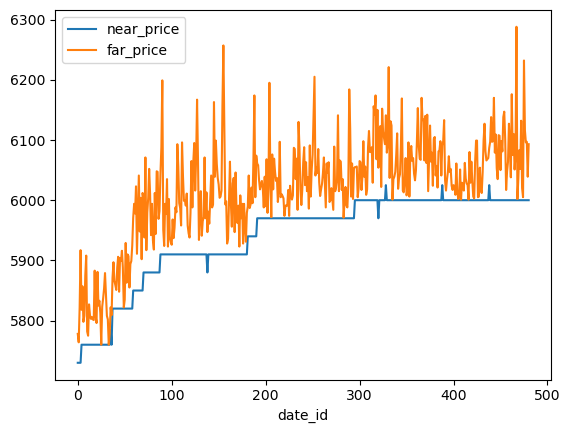

In [56]:
df[df['near_price'].isnull()].groupby('date_id').size().plot(label='near_price')
df[df['far_price'].isnull()].groupby('date_id').size().plot(label='far_price')
plt.legend(loc='upper left')

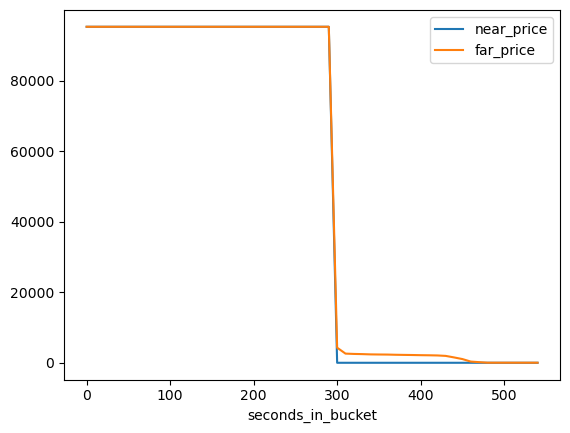

In [57]:
df[df['near_price'].isnull()].groupby('seconds_in_bucket').size().plot(label='near_price')
df[df['far_price'].isnull()].groupby('seconds_in_bucket').size().plot(label='far_price')
plt.legend()

From this, we know they don't have data before 5min, but far price still have missing values after 5min.

#### 5. Non-auction book

bid_price <= wap <= ask_price

<Axes: xlabel='seconds_in_bucket'>

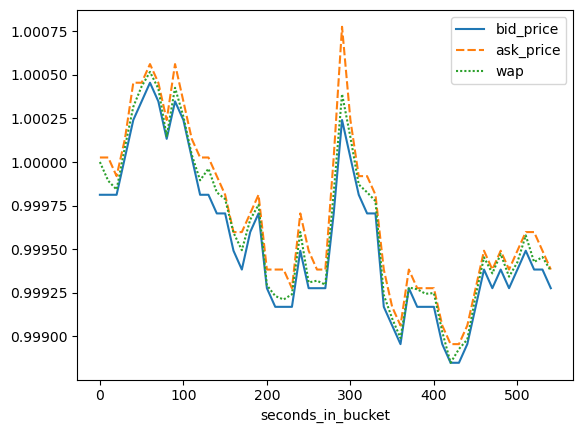

In [58]:
(
    df.query('stock_id == 0 and date_id == 0')
    .set_index('seconds_in_bucket')
    [['bid_price', 'ask_price', 'wap']]
    .pipe(
        sns.lineplot
    )
)

#### 6. Targets and wap

In [59]:
# pd.set_option('display.max_rows', 0)
df[df['target'].isnull()]

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
369508,131,35,0,NaN,0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,1925,35_0_131
369700,131,35,10,NaN,0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,1926,35_10_131
369892,131,35,20,NaN,0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,1927,35_20_131
370084,131,35,30,NaN,0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,1928,35_30_131
370276,131,35,40,NaN,0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,1929,35_40_131
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4225338,158,388,510,NaN,0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,21391,388_510_158
4225538,158,388,520,NaN,0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,21392,388_520_158
4225738,158,388,530,NaN,0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,21393,388_530_158
4225938,158,388,540,NaN,0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0.0,NaN,NaN,21394,388_540_158


So there're 88 rows of missing target

In [60]:
df[df['wap'].isnull() & df['target'].notnull()][['imbalance_size', 'reference_price', 'matched_size', 'far_price', 'near_price', 'bid_price', 'ask_price', 'wap']].isnull().all()

imbalance_size     True
reference_price    True
matched_size       True
far_price          True
near_price         True
bid_price          True
ask_price          True
wap                True
dtype: bool

In [142]:
df.eval('bid_size + ask_size')

0           69144.53
1           23838.13
2           56951.00
3          481357.30
4           16919.64
             ...    
5237975    352119.44
5237976    298501.47
5237977    196828.98
5237978    795524.72
5237979    550249.00
Length: 5237980, dtype: float64

In [144]:
df.eval('imbalance_size * 2 + matched_size')

0          19741482.02
1           1975422.07
2           2425127.77
3          42225110.16
4          18755714.87
              ...     
5237975    33161807.52
5237976     9886720.05
5237977    12725436.10
5237978    96775068.73
5237979    27842248.74
Length: 5237980, dtype: float64

Which we find that there're 132 rows missing wap, and those rows also have missing values: 'imbalance_size', 'reference_price', 'matched_size', 'far_price', 'near_price', 'bid_price', 'ask_price', which saves us a lot of time.

In [61]:
inspect_columns(df[df['wap'].notnull() & df['target'].notnull()])

,len,unique,cardinality,null_cnt,null_pct,1st_row,random_row,last_row,dtype
stock_id,5237760,False,200,0,0.000000,0,149,199,int64
date_id,5237760,False,481,0,0.000000,0,352,480,int64
seconds_in_bucket,5237760,False,55,0,0.000000,0,20,540,int64
imbalance_size,5237760,False,2971863,0,0.000000,3180602.69,6482811.23,1884285.71,float64
imbalance_buy_sell_flag,5237760,False,3,0,0.000000,1,-1,-1,int64
reference_price,5237760,False,28741,0,0.000000,0.999812,0.998806,1.002129,float64
matched_size,5237760,False,2948862,0,0.000000,13380276.64,5678550.71,24073677.32,float64
far_price,5237760,False,95739,2894122,55.254956,NaN,NaN,1.000859,float64
near_price,5237760,False,84625,2856960,54.545455,NaN,NaN,1.001494,float64
bid_price,5237760,False,28313,0,0.000000,0.999812,0.998693,1.002129,float64


### Dealing with Missing value 

1. remove all rows with NA target
2. remove all rows with NA wap
3. Fill far_price and near_price with 0, because in real life, people also don't know those values
4. drop all other rows, because after 5min, the data is known public, but we don't know.

In [62]:
# step 1,2 
df_cleaned = (
    df.dropna(subset='target')
    .dropna(subset='wap')
)

# step 3
df_cleaned.loc[(df_cleaned['seconds_in_bucket'] <= 300) & (df_cleaned['far_price'].isnull()), 'far_price'] = 0
df_cleaned.loc[(df_cleaned['seconds_in_bucket'] <= 300) & (df_cleaned['near_price'].isnull()), 'near_price'] = 0

# step 4:
df_cleaned = df_cleaned.dropna().reset_index(drop=True)

inspect_columns(df_cleaned)

,len,unique,cardinality,null_cnt,null_pct,1st_row,random_row,last_row,dtype
stock_id,5204879,False,200,0,0.0,0,125,199,int64
date_id,5204879,False,481,0,0.0,0,77,480,int64
seconds_in_bucket,5204879,False,55,0,0.0,0,330,540,int64
imbalance_size,5204879,False,2951166,0,0.0,3180602.69,512742.15,1884285.71,float64
imbalance_buy_sell_flag,5204879,False,3,0,0.0,1,-1,-1,int64
reference_price,5204879,False,28334,0,0.0,0.999812,0.998195,1.002129,float64
matched_size,5204879,False,2929571,0,0.0,13380276.64,5654993.31,24073677.32,float64
far_price,5204879,False,95740,0,0.0,0.0,0.978505,1.000859,float64
near_price,5204879,False,78759,0,0.0,0.0,0.997506,1.001494,float64
bid_price,5204879,False,27937,0,0.0,0.999812,0.998146,1.002129,float64


In [63]:
len(df_cleaned) / len(df)

0.9936805791545595

### Univariate analysis

<Axes: xlabel='seconds_in_bucket'>

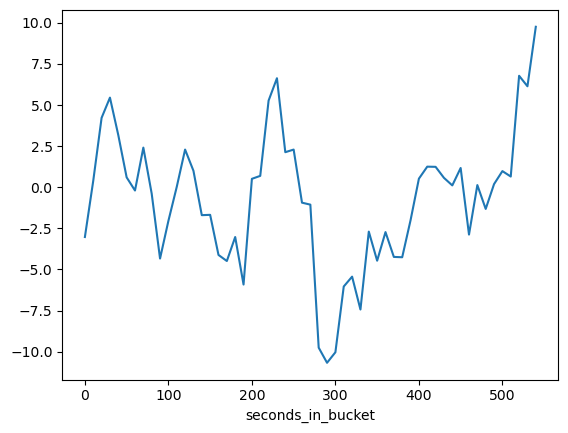

In [64]:
(
    df_cleaned.query('stock_id == 0 and date_id == 0')
    .set_index('seconds_in_bucket')
    ['target'].plot()
)

### Bivariate analysis

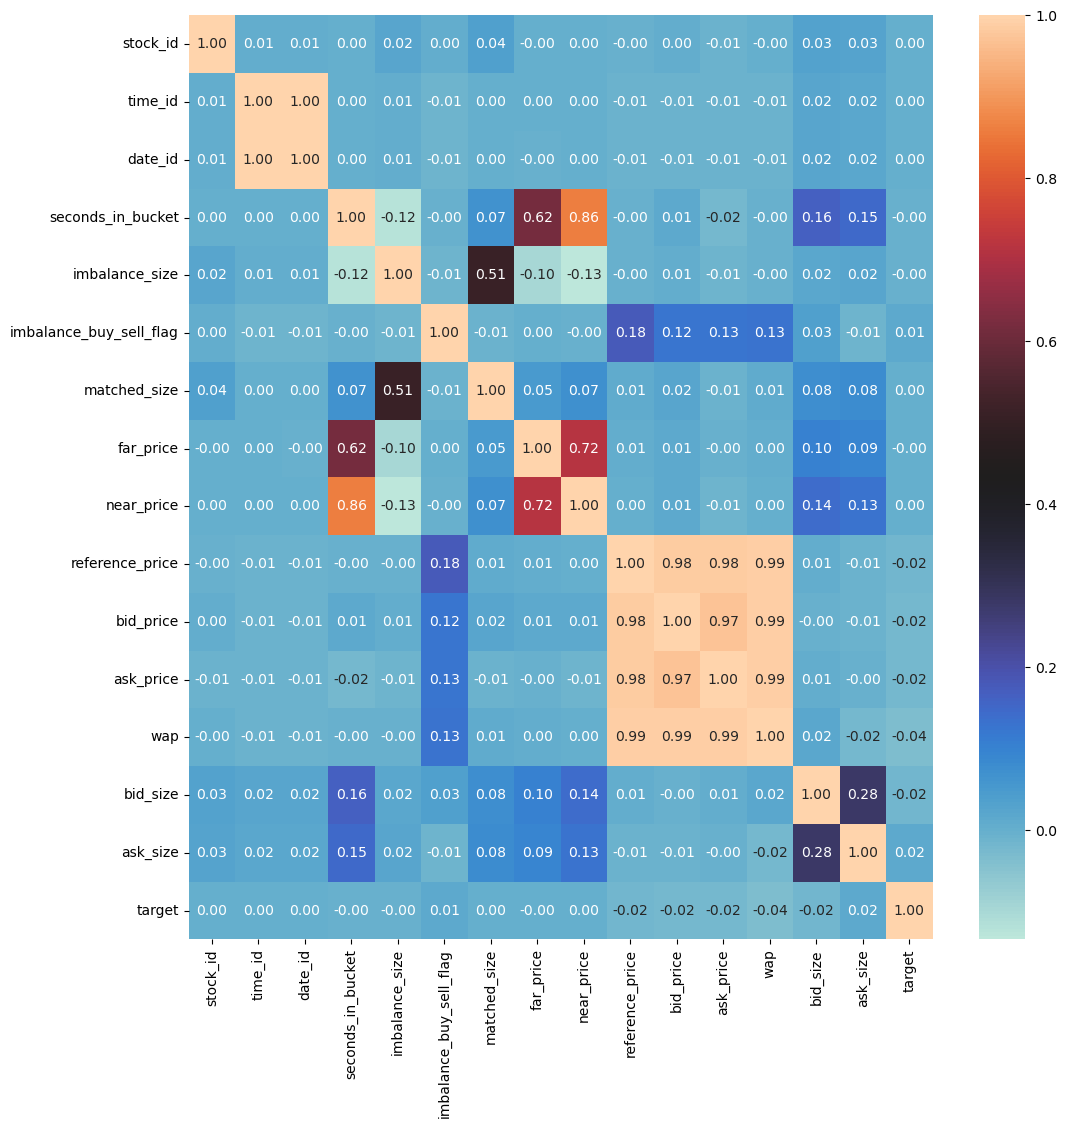

In [65]:
fig, ax = plt.subplots(figsize=(12,12))
cor_matrix = (
    df_cleaned[[
        'stock_id', 'time_id', 'date_id', 'seconds_in_bucket',
        'imbalance_size', 'imbalance_buy_sell_flag', 'matched_size',
        'far_price', 'near_price', 'reference_price', 
        'bid_price', 'ask_price', 'wap', 'bid_size', 'ask_size',
        'target']].corr()
)
sns.heatmap(cor_matrix, cmap='icefire', annot=True, fmt='.2f', ax=ax)
plt.show()

#### Multicollinearity

In [66]:
# VIF Factor
import pandas as pd
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Sample data
# Add a constant for the intercept term in the regression
X = sm.add_constant(df_cleaned.drop(['target', 'row_id'], axis=1))

# Calculate VIF for each feature
vif = pd.DataFrame()
vif["features"] = X.columns
vif["VIF_Factor"] = [variance_inflation_factor(X, i) for i in range(X.shape[1])]
vif.sort_values('VIF_Factor', ascending=False)

/Users/yuwensun/Documents/Kaggle/optiver-trading-at-the-close/.conda/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1783: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/Users/yuwensun/Documents/Kaggle/optiver-trading-at-the-close/.conda/lib/python3.11/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


,features,VIF_Factor
2,date_id,inf
15,time_id,inf
3,seconds_in_bucket,4.503600e+15
14,wap,1.295440e+02
6,reference_price,6.651258e+01
12,ask_price,6.467894e+01
10,bid_price,6.418803e+01
9,near_price,4.985760e+00
8,far_price,2.054041e+00
4,imbalance_size,1.414952e+00


## Feature Engineering

In [67]:
df_cleaned

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
0,0,0,0,3180602.69,1,0.999812,13380276.64,0.000000,0.000000,0.999812,60651.50,1.000026,8493.03,1.000000,-3.029704,0,0_0_0
1,1,0,0,166603.91,-1,0.999896,1642214.25,0.000000,0.000000,0.999896,3233.04,1.000660,20605.09,1.000000,-5.519986,0,0_0_1
2,2,0,0,302879.87,-1,0.999561,1819368.03,0.000000,0.000000,0.999403,37956.00,1.000298,18995.00,1.000000,-8.389950,0,0_0_2
3,3,0,0,11917682.27,-1,1.000171,18389745.62,0.000000,0.000000,0.999999,2324.90,1.000214,479032.40,1.000000,-4.010200,0,0_0_3
4,4,0,0,447549.96,-1,0.999532,17860614.95,0.000000,0.000000,0.999394,16485.54,1.000016,434.10,1.000000,-7.349849,0,0_0_4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5204874,195,480,540,2440722.89,-1,1.000317,28280361.74,0.999734,0.999734,1.000317,32257.04,1.000434,319862.40,1.000328,2.310276,26454,480_540_195
5204875,196,480,540,349510.47,-1,1.000643,9187699.11,1.000129,1.000386,1.000643,205108.40,1.000900,93393.07,1.000819,-8.220077,26454,480_540_196
5204876,197,480,540,0.00,0,0.995789,12725436.10,0.995789,0.995789,0.995789,16790.66,0.995883,180038.32,0.995797,1.169443,26454,480_540_197
5204877,198,480,540,1000898.84,1,0.999210,94773271.05,0.999210,0.999210,0.998970,125631.72,0.999210,669893.00,0.999008,-1.540184,26454,480_540_198


<Axes: xlabel='seconds_in_bucket'>

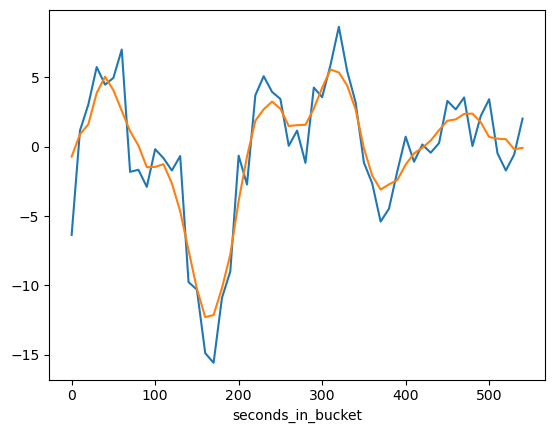

In [104]:
(
    df_cleaned.set_index('seconds_in_bucket')
    .query('stock_id == 0 and date_id == 2')['target']
    .plot()
)

(
    df_cleaned.set_index('seconds_in_bucket')
    .query('stock_id == 0 and date_id == 2')['target']
    .rolling(5, center=True, min_periods=0).mean().plot()
)

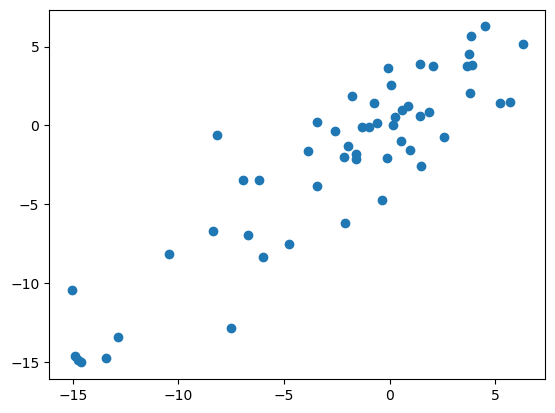

In [140]:
x = (
    df_cleaned.set_index('seconds_in_bucket')
    .query('stock_id == 0 and date_id == 5')['target']
)
y = (
    df_cleaned.set_index('seconds_in_bucket')
    .query('stock_id == 0 and date_id == 5')['target'].shift(1)
)

plt.scatter(x, y)

In [127]:
from statsmodels.graphics.tsaplots import plot_pacf

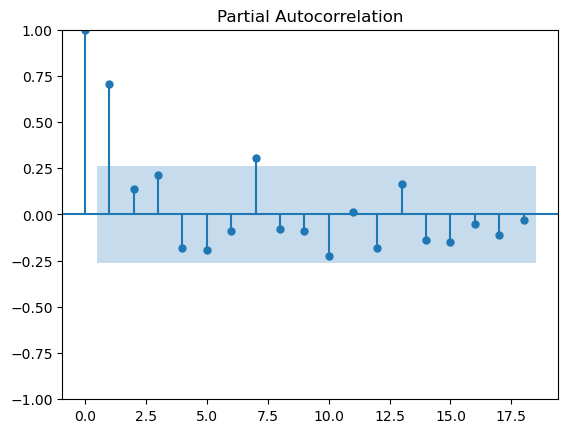

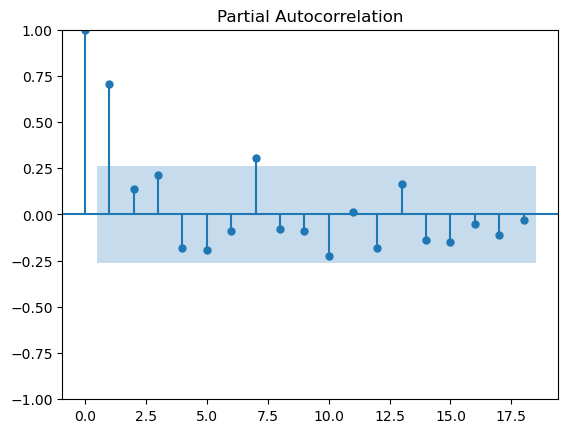

In [134]:
plot_pacf(df_cleaned.set_index('seconds_in_bucket').query('stock_id == 0 and date_id == 11')['target'])

Observation
1. time_id and date_id, we only need to keep one, so we choose time_id because output file contains it.

2. 4 prices: reference price, bid_price, ask_price, and wap are all highly correlated, we choose wap because it shows more information.

In [38]:
df_cleaned = (
    df_cleaned.drop(['date_id', 'reference_price', 'bid_price', 'ask_price'], axis=1)
    [['row_id', 'time_id', 'stock_id', 'seconds_in_bucket',
      'imbalance_size', 'matched_size', 'imbalance_buy_sell_flag',
      'far_price', 'near_price', 'wap', 'bid_size', 'ask_size', 'target'
    ]]
)
df_cleaned

,row_id,time_id,stock_id,seconds_in_bucket,imbalance_size,matched_size,imbalance_buy_sell_flag,far_price,near_price,wap,bid_size,ask_size,target
0,0_0_0,0,0,0,3180602.69,13380276.64,1,0.000000,0.000000,1.000000,60651.50,8493.03,-3.029704
1,0_0_1,0,1,0,166603.91,1642214.25,-1,0.000000,0.000000,1.000000,3233.04,20605.09,-5.519986
2,0_0_2,0,2,0,302879.87,1819368.03,-1,0.000000,0.000000,1.000000,37956.00,18995.00,-8.389950
3,0_0_3,0,3,0,11917682.27,18389745.62,-1,0.000000,0.000000,1.000000,2324.90,479032.40,-4.010200
4,0_0_4,0,4,0,447549.96,17860614.95,-1,0.000000,0.000000,1.000000,16485.54,434.10,-7.349849
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5204874,480_540_195,26454,195,540,2440722.89,28280361.74,-1,0.999734,0.999734,1.000328,32257.04,319862.40,2.310276
5204875,480_540_196,26454,196,540,349510.47,9187699.11,-1,1.000129,1.000386,1.000819,205108.40,93393.07,-8.220077
5204876,480_540_197,26454,197,540,0.00,12725436.10,0,0.995789,0.995789,0.995797,16790.66,180038.32,1.169443
5204877,480_540_198,26454,198,540,1000898.84,94773271.05,1,0.999210,0.999210,0.999008,125631.72,669893.00,-1.540184


Because **row_id** is string, so we should drop it to caculate bivariate correlation

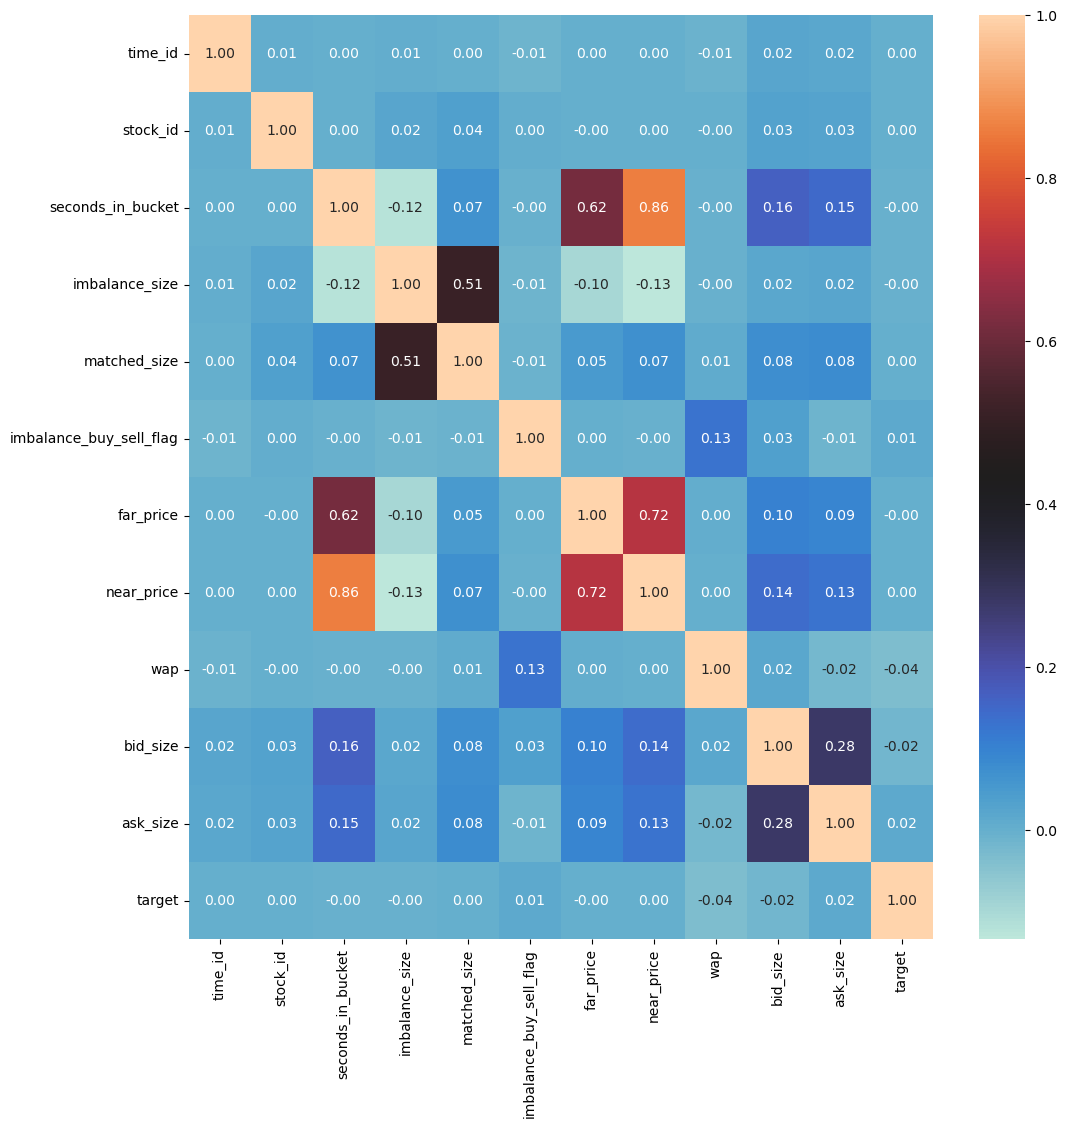

In [39]:
fig, ax = plt.subplots(figsize=(12,12))
cor_matrix = df_cleaned.corr(numeric_only=True)
sns.heatmap(cor_matrix, cmap='icefire', annot=True, fmt='.2f', ax=ax)
plt.show()

<Axes: >

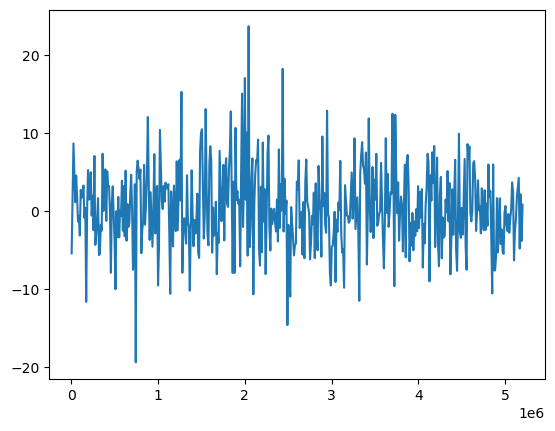

In [40]:
df_cleaned.query('stock_id == 0 and seconds_in_bucket == 320')['target'].plot()

<Axes: xlabel='imbalance_size', ylabel='target'>

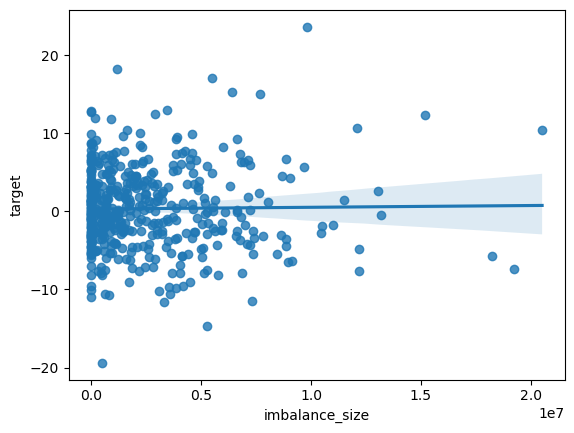

In [41]:
sns.regplot(x='imbalance_size', y='target', data=df_cleaned.query('stock_id == 0 and seconds_in_bucket == 320')[['imbalance_size', 'target']])

In [61]:
# df_cleaned.to_csv('df_cleaned.csv', index=False)

In [178]:
timestamps_1 = pd.date_range(start="2023-01-01", periods=10, freq="D")
values_1 = np.random.randint(1, 100, size=10)

df1 = pd.DataFrame({
    "timestamp": timestamps_1,
    "value": values_1
})
df1

,timestamp,value
0,2023-01-01,67
1,2023-01-02,57
2,2023-01-03,90
3,2023-01-04,30
4,2023-01-05,88
5,2023-01-06,13
6,2023-01-07,62
7,2023-01-08,17
8,2023-01-09,59
9,2023-01-10,54


In [179]:
# Target timestamps for rolling join
timestamps_2 = pd.date_range(start="2023-01-03", periods=5, freq="2D")

df2 = pd.DataFrame({
    "target_timestamp": timestamps_2
})
df2

,target_timestamp
0,2023-01-03
1,2023-01-05
2,2023-01-07
3,2023-01-09
4,2023-01-11


In [183]:
pd.merge_asof(df1, df2, left_on='timestamp', right_on='target_timestamp', direction='nearest')

,timestamp,value,target_timestamp
0,2023-01-01,67,2023-01-03
1,2023-01-02,57,2023-01-03
2,2023-01-03,90,2023-01-03
3,2023-01-04,30,2023-01-03
4,2023-01-05,88,2023-01-05
5,2023-01-06,13,2023-01-05
6,2023-01-07,62,2023-01-07
7,2023-01-08,17,2023-01-07
8,2023-01-09,59,2023-01-09
9,2023-01-10,54,2023-01-09


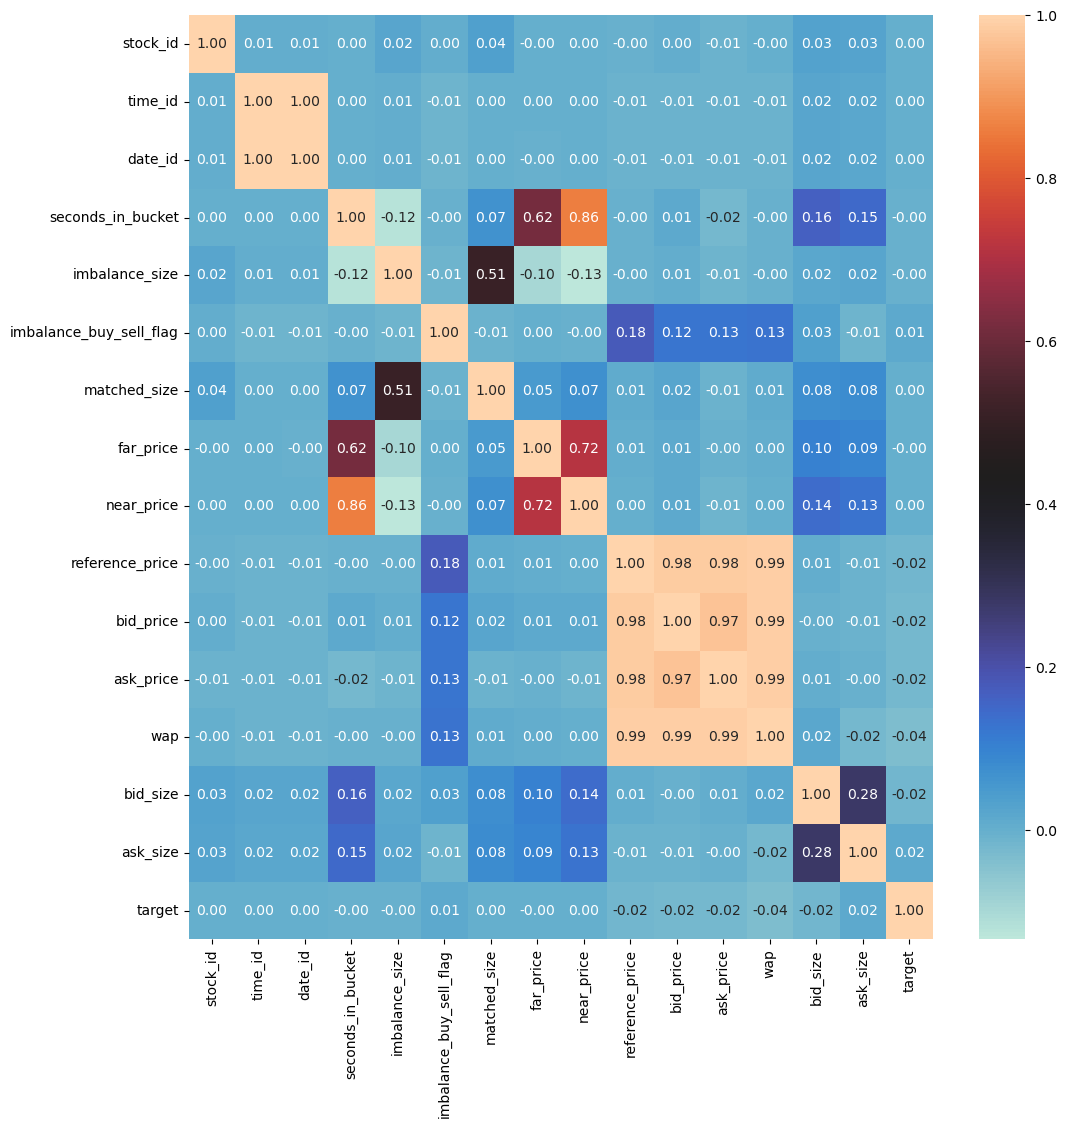

In [ ]:
fig, ax = plt.subplots(figsize=(12,12))
cor_matrix = (
    df_cleaned[[
        'stock_id', 'time_id', 'date_id', 'seconds_in_bucket',
        'imbalance_size', 'imbalance_buy_sell_flag', 'matched_size',
        'far_price', 'near_price', 'reference_price', 
        'bid_price', 'ask_price', 'wap', 'bid_size', 'ask_size',
        'target']].corr()
)
sns.heatmap(cor_matrix, cmap='icefire', annot=True, fmt='.2f', ax=ax)
plt.show()

Observation
1. time_id and date_id, we only need to keep one, so we choose time_id because output file contains it.

2. 4 prices: reference price, bid_price, ask_price, and wap are all highly correlated, we choose wap because it shows more information.

In [ ]:
df_cleaned = (
    df_cleaned.drop(['date_id', 'reference_price', 'bid_price', 'ask_price'], axis=1)
    [['row_id', 'time_id', 'stock_id', 'seconds_in_bucket',
      'imbalance_size', 'matched_size', 'imbalance_buy_sell_flag',
      'far_price', 'near_price', 'wap', 'bid_size', 'ask_size', 'target'
    ]]
)
df_cleaned

,row_id,time_id,stock_id,seconds_in_bucket,imbalance_size,matched_size,imbalance_buy_sell_flag,far_price,near_price,wap,bid_size,ask_size,target
0,0_0_0,0,0,0,3180602.69,13380276.64,1,0.000000,0.000000,1.000000,60651.50,8493.03,-3.029704
1,0_0_1,0,1,0,166603.91,1642214.25,-1,0.000000,0.000000,1.000000,3233.04,20605.09,-5.519986
2,0_0_2,0,2,0,302879.87,1819368.03,-1,0.000000,0.000000,1.000000,37956.00,18995.00,-8.389950
3,0_0_3,0,3,0,11917682.27,18389745.62,-1,0.000000,0.000000,1.000000,2324.90,479032.40,-4.010200
4,0_0_4,0,4,0,447549.96,17860614.95,-1,0.000000,0.000000,1.000000,16485.54,434.10,-7.349849
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5204874,480_540_195,26454,195,540,2440722.89,28280361.74,-1,0.999734,0.999734,1.000328,32257.04,319862.40,2.310276
5204875,480_540_196,26454,196,540,349510.47,9187699.11,-1,1.000129,1.000386,1.000819,205108.40,93393.07,-8.220077
5204876,480_540_197,26454,197,540,0.00,12725436.10,0,0.995789,0.995789,0.995797,16790.66,180038.32,1.169443
5204877,480_540_198,26454,198,540,1000898.84,94773271.05,1,0.999210,0.999210,0.999008,125631.72,669893.00,-1.540184


Because **row_id** is string, so we should drop it to caculate bivariate correlation

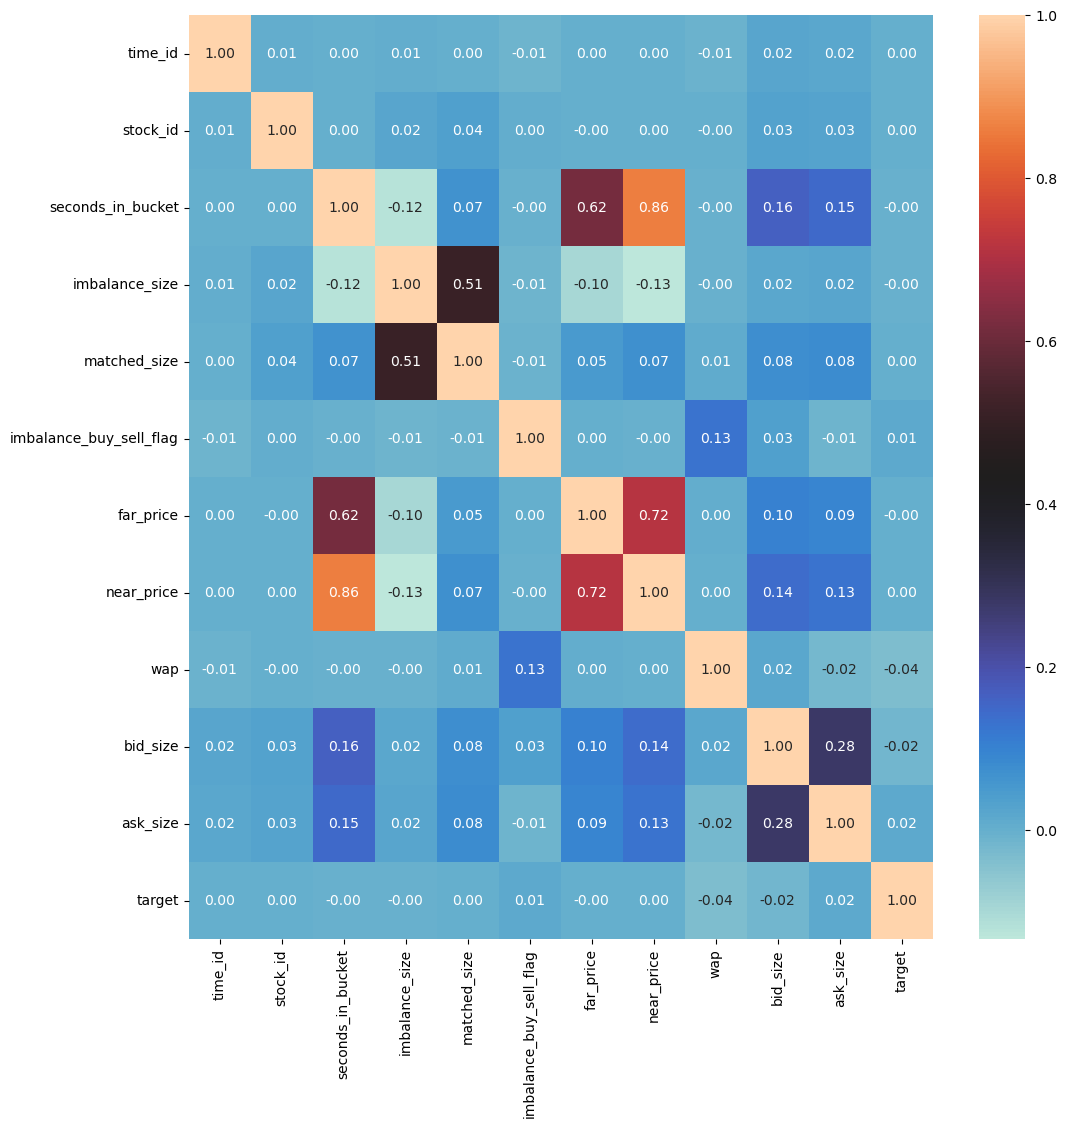

In [ ]:
fig, ax = plt.subplots(figsize=(12,12))
cor_matrix = df_cleaned.corr(numeric_only=True)
sns.heatmap(cor_matrix, cmap='icefire', annot=True, fmt='.2f', ax=ax)
plt.show()

<Axes: >

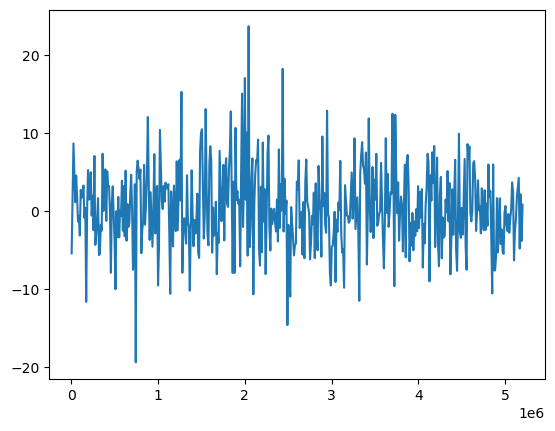

In [ ]:
df_cleaned.query('stock_id == 0 and seconds_in_bucket == 320')['target'].plot()

<Axes: xlabel='imbalance_size', ylabel='target'>

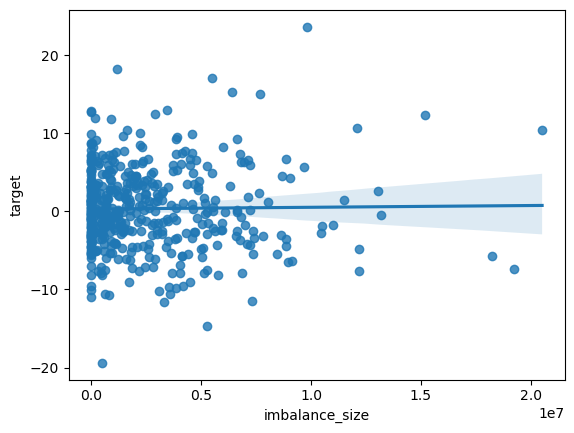

In [ ]:
sns.regplot(x='imbalance_size', y='target', data=df_cleaned.query('stock_id == 0 and seconds_in_bucket == 320')[['imbalance_size', 'target']])

/Users/yuwensun/Documents/Kaggle/optiver-trading-at-the-close/.conda/lib/python3.11/site-packages/statsmodels/regression/linear_model.py:1783: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


,features,VIF_Factor
8,near_price,4.983807
3,seconds_in_bucket,3.949502
7,far_price,2.054031
4,imbalance_size,1.412813
5,matched_size,1.402236
10,bid_size,1.111101
11,ask_size,1.104634
6,imbalance_buy_sell_flag,1.018592
9,wap,1.017635
2,stock_id,1.002629


### Time-series Train-test Split

The Strategy is: use first 400days as dev set and 81days are test set.

In [14]:
df_cleaned_dataset = df_cleaned.drop('row_id', axis=1)
df_cleaned_dataset

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,...,ask_price_reference_price_imb,bid_price_reference_price_imb,bid_price_ask_price_imb,wap_reference_price_imb,wap_ask_price_imb,wap_bid_price_imb,bid_price_ask_price_reference_price_imb2,wap_ask_price_reference_price_imb2,wap_bid_price_reference_price_imb2,wap_bid_price_ask_price_imb2
0,0,0,0,3180602.69,1,0.999812,13380276.64,0.000000,0.000000,0.999812,...,0.000107,0.000000,-0.000107,0.000094,-0.000013,9.400884e-05,-1.927541e+12,1.382979e-01,-1.693353e+12,0.138298
1,1,0,0,166603.91,-1,0.999896,1642214.25,0.000000,0.000000,0.999896,...,0.000382,0.000000,-0.000382,0.000052,-0.000330,5.200270e-05,-6.881500e+12,6.346154e+00,9.367487e+11,6.346154
2,2,0,0,302879.87,-1,0.999561,1819368.03,0.000000,0.000000,0.999403,...,0.000369,-0.000079,-0.000448,0.000220,-0.000149,2.985891e-04,4.664557e+00,6.788155e-01,2.778481e+00,0.499162
3,3,0,0,11917682.27,-1,1.000171,18389745.62,0.000000,0.000000,0.999999,...,0.000021,-0.000086,-0.000107,-0.000085,-0.000107,5.000003e-07,2.500000e-01,2.514620e-01,1.710000e+02,214.000000
4,4,0,0,447549.96,-1,0.999532,17860614.95,0.000000,0.000000,0.999394,...,0.000242,-0.000069,-0.000311,0.000234,-0.000008,3.030918e-04,3.507246e+00,3.418803e-02,3.391304e+00,0.026403
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5204874,195,480,540,2440722.89,-1,1.000317,28280361.74,0.999734,0.999734,1.000317,...,0.000058,0.000000,-0.000058,0.000005,-0.000053,5.498227e-06,5.269212e+11,9.636364e+00,inf,9.636364
5204875,196,480,540,349510.47,-1,1.000643,9187699.11,1.000129,1.000386,1.000643,...,0.000128,0.000000,-0.000128,0.000088,-0.000040,8.793572e-05,inf,4.602273e-01,7.926335e+11,0.460227
5204876,197,480,540,0.00,0,0.995789,12725436.10,0.995789,0.995789,0.995789,...,0.000047,0.000000,-0.000047,0.000004,-0.000043,4.016899e-06,-2.822256e+11,1.075000e+01,inf,10.750000
5204877,198,480,540,1000898.84,1,0.999210,94773271.05,0.999210,0.999210,0.998970,...,0.000000,-0.000120,-0.000120,-0.000101,-0.000101,1.901923e-05,-9.251859e-13,-1.099231e-12,5.315789e+00,5.315789


In [63]:
df_cleaned_dev = df_cleaned_dataset.query('time_id < 400*55')
df_cleaned_test = df_cleaned_dataset.query('time_id >= 400*55')
group_label = df_cleaned_dev['time_id'].apply(lambda x: x//(80*55))
group_label

0          0
1          0
2          0
3          0
4          0
          ..
4318747    4
4318748    4
4318749    4
4318750    4
4318751    4
Name: time_id, Length: 4318752, dtype: int64

In [64]:
X_dev, y_dev = df_cleaned_dev.drop(['target'], axis=1), df_cleaned_dev['target']
X_test, y_test = df_cleaned_test.drop(['target'], axis=1), df_cleaned_test['target']

In [65]:
cv_args = {"test_size": 1, "train_size": 1}
# Initialize your GroupTimeSeriesSplit
cv = GroupTimeSeriesSplit(**cv_args).split(X_dev, y_dev, groups=group_label)

KeyboardInterrupt: 

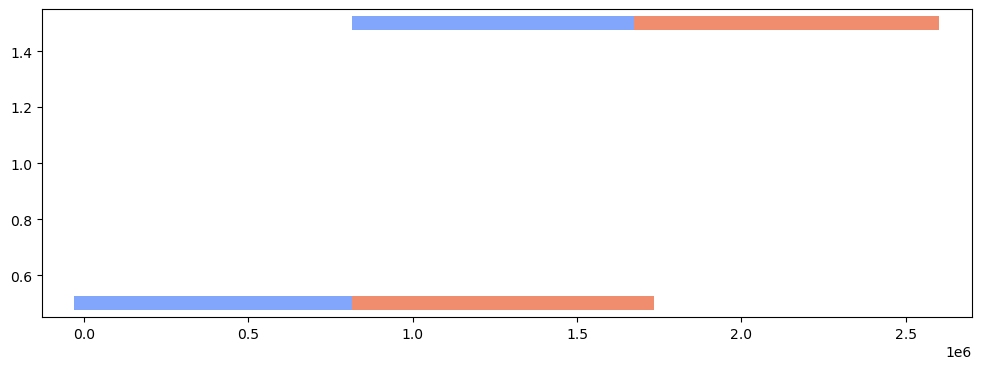

In [33]:
plot_splits(X=X_dev, y=y_dev, groups=group_label, **cv_args)
# print_split_info(X=df_cleaned.drop(['date_id', 'target'], axis=1), y=df_cleaned['target'], groups=df_cleaned['group_label'], **cv_args)

### Loss function

In [35]:
# Define custom MAE scorer
def mae(y, y_pred):
    n = len(y)
    return abs(y - y_pred).sum() / n

# Wrap it with make_scorer for use in GridSearchCV
mae_scorer = make_scorer(mae, greater_is_better=False)  # MAE needs to be minimized

### Linear Regression baseline

KeyboardInterrupt: 

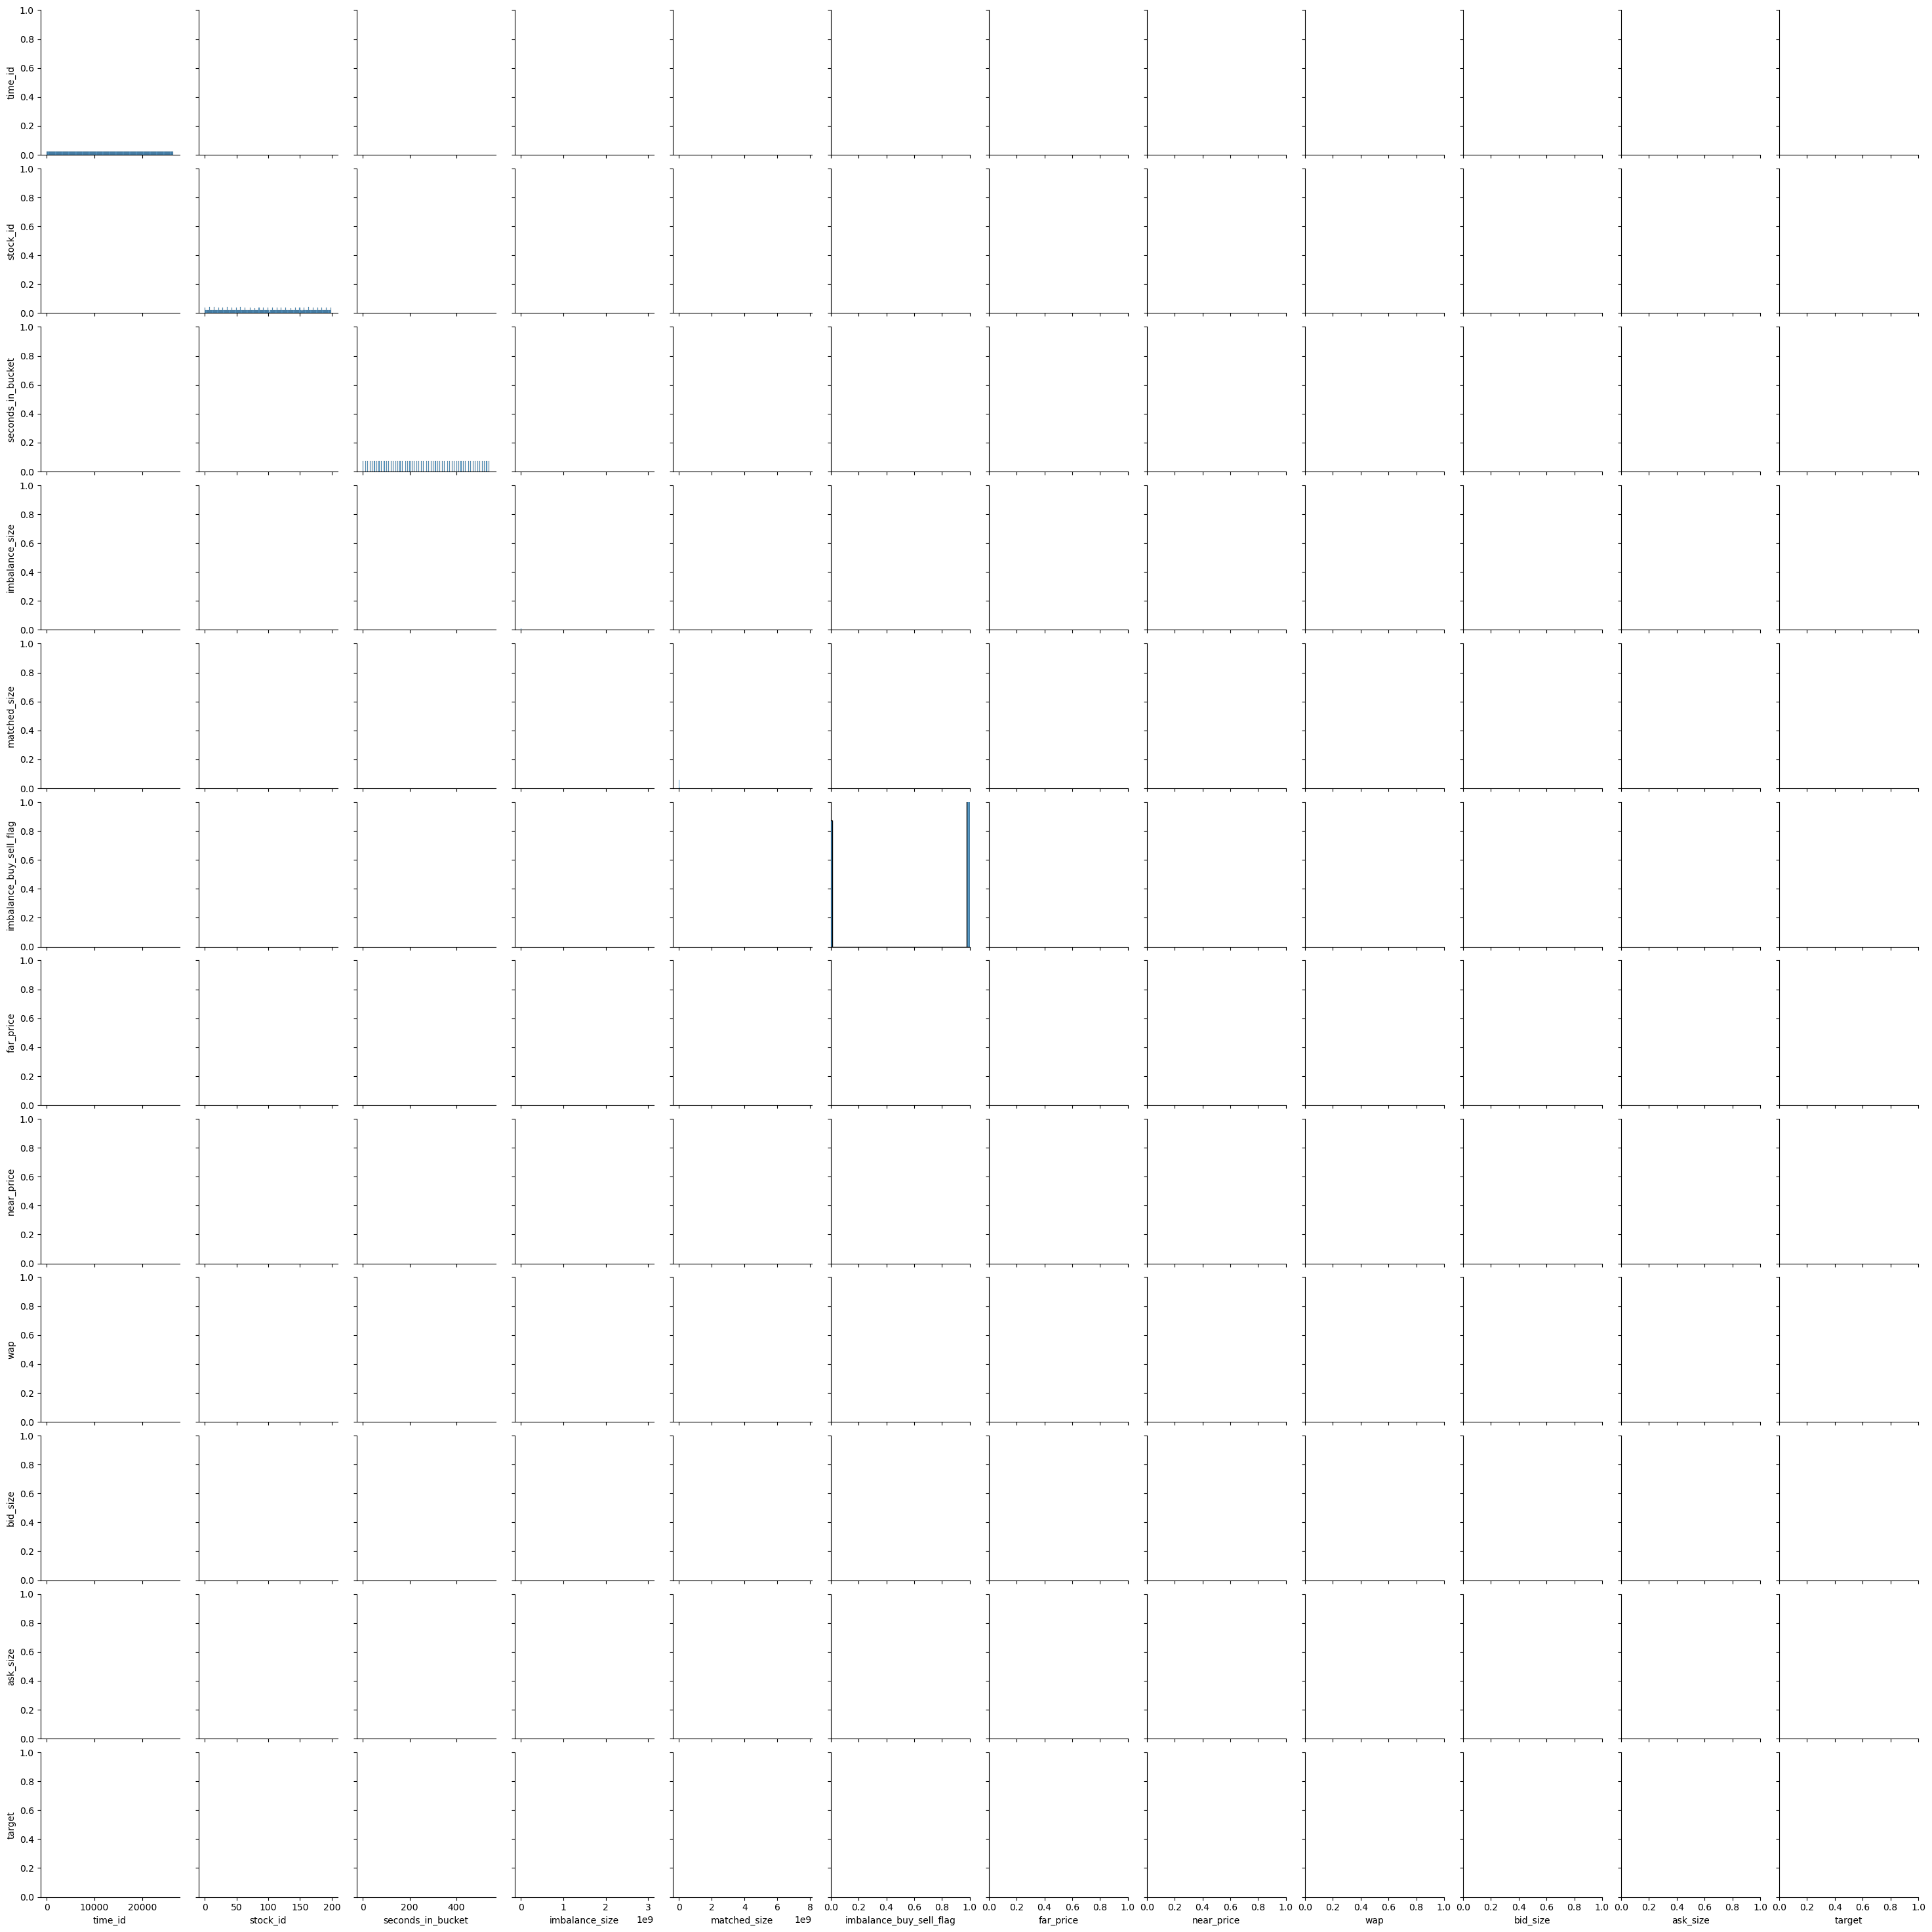

In [36]:
sns.pairplot(df_cleaned)

In [278]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score

In [283]:
pipe = make_pipeline(
    # PolynomialFeatures(2),
    LinearRegression(fit_intercept=True)
)

In [284]:
pipe.fit(X_dev, y_dev)

Pipeline(steps=[('linearregression', LinearRegression())])

In [285]:
y_pred = pipe.predict(X_test)
# model.intercept_

In [286]:
r2_score(y_test, y_pred)

0.0007486193604729907

In [272]:
mae(y_test, y_pred)

5.981422558419439

<Axes: >

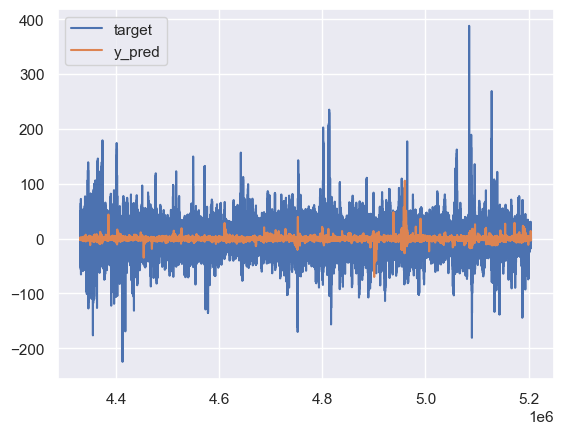

In [282]:
pd.concat([
    y_test.to_frame(), 
    pd.DataFrame({"y_pred": y_pred}, index=y_test.index)
    ], axis=1).plot()

In [242]:
from sklearn.metrics import mean_absolute_error

In [273]:
mean_absolute_error(y_test, y_pred)

5.981422558419439

In [232]:
import statsmodels.api as sm

In [234]:
model = sm.OLS(y_dev, X_dev)
results = model.fit()

In [237]:
mae(results.predict(X_test), y_test)

5.982164710660948

In [241]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 target   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     556.3
Date:                Wed, 20 Nov 2024   Prob (F-statistic):               0.00
Time:                        16:31:30   Log-Likelihood:            -1.5897e+07
No. Observations:             4329730   AIC:                         3.179e+07
Df Residuals:                 4329720   BIC:                         3.179e+07
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
===========================================================================================
                              coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------
stock_id                    0.0001    7.9e-05      1.496      0.135   -3.67e-05       0.000
seconds_in_bucket          -0.0010   5.71e-05    -16.932      0.000      -0.001      -0.001
imbalance_size           1.478e-11   2.66e-10      0.056      0.956   -5.07e-10    5.36e-10
matched_size             8.084e-11   3.91e-11      2.065      0.039    4.12e-12    1.58e-10
imbalance_buy_sell_flag     0.1889      0.005     36.260      0.000       0.179       0.199
far_price                  -0.0211      0.009     -2.451      0.014      -0.038      -0.004
near_price                  0.3250      0.020     16.123      0.000       0.285       0.364
wap                         0.0777      0.013      5.934      0.000       0.052       0.103
bid_size                -2.122e-06   4.35e-08    -48.742      0.000   -2.21e-06   -2.04e-06
ask_size                 1.697e-06   3.78e-08     44.913      0.000    1.62e-06    1.77e-06
==============================================================================
Omnibus:                  1116884.597   Durbin-Watson:                   1.971
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         86583190.258
Skew:                           0.197   Prob(JB):                         0.00
Kurtosis:                      24.904   Cond. No.                     6.66e+08
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.66e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [257]:
from sklearn.model_selection import validation_curve

In [296]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.pipeline import make_pipeline, Pipeline

In [320]:
pipeline = make_pipeline(
    PCA(n_components=10),
    StandardScaler(),
    LinearRegression(fit_intercept=True)
)

pipeline.fit(X_dev, y_dev)
pipeline.named_steps['linearregression'].coef_

array([ 6.79922447e-11, -1.04616308e-10,  3.22824671e-07, -2.64030883e-06,
       -1.76312328e-04,  9.33238814e-05,  1.89258235e-01,  4.60752481e-02,
        3.26159913e-01, -1.48942967e+02])

In [321]:
mae(y_test, pipeline.predict(X_test))

5.98142255841938

In [282]:
from sklearn.decomposition import PCA
model = PCA(n_components=10)
pd.DataFrame(model.fit_transform(X_dev))

,0,1,2,3,4,5,6,7,8,9
0,-3.118451e+07,-1.365460e+05,-28858.160104,31831.260702,-263.677902,-99.314186,0.981271,0.312066,0.208278,-0.000399
1,-4.311128e+07,-2.285622e+06,-47586.199830,-23415.873618,-258.197497,-97.466990,-0.998847,0.327228,0.206475,0.000348
2,-4.292465e+07,-2.162646e+06,-30911.125731,7088.194186,-263.790903,-96.880165,-1.010768,0.327148,0.206617,0.000333
3,-2.555057e+07,8.211472e+06,343889.156843,-262314.051349,-299.510624,-99.448620,-0.922652,0.335443,0.212035,0.000559
4,-2.691564e+07,-3.189363e+06,-59706.925738,-1892.492515,-260.409008,-94.693175,-1.006014,0.325250,0.205221,0.000328
5,-3.124456e+07,-3.321254e+06,-62397.800744,-16948.109612,-258.531018,-93.487636,-0.000631,0.316800,0.205302,-0.000022
6,-4.105270e+07,-1.630784e+06,-60229.207919,-11764.496638,-255.705857,-92.434419,0.997586,0.311079,0.207286,-0.000379
7,-2.286961e+07,5.503882e+06,-62501.253493,-12435.965755,-244.434275,-91.898069,1.001511,0.319867,0.213032,-0.000373
8,-3.513852e+07,-6.349596e+05,-38456.295487,27778.223613,-262.009873,-91.088313,0.982680,0.311804,0.208010,-0.000398
...,...,...,...,...,...,...,...,...,...,...


In [281]:
X_dev

,stock_id,seconds_in_bucket,imbalance_size,matched_size,imbalance_buy_sell_flag,far_price,near_price,wap,bid_size,ask_size
0,0,0,3180602.69,1.338028e+07,1,0.000000,0.000000,1.000000,60651.50,8493.03
1,1,0,166603.91,1.642214e+06,-1,0.000000,0.000000,1.000000,3233.04,20605.09
2,2,0,302879.87,1.819368e+06,-1,0.000000,0.000000,1.000000,37956.00,18995.00
3,3,0,11917682.27,1.838975e+07,-1,0.000000,0.000000,1.000000,2324.90,479032.40
4,4,0,447549.96,1.786061e+07,-1,0.000000,0.000000,1.000000,16485.54,434.10
5,5,0,0.00,1.355288e+07,0,0.000000,0.000000,1.000000,1962.72,5647.65
6,6,0,969969.40,3.647504e+06,1,0.000000,0.000000,1.000000,6663.16,3810.48
7,7,0,9412959.10,2.126125e+07,1,0.000000,0.000000,1.000000,5139.20,2570.60
8,8,0,2394875.85,9.473209e+06,1,0.000000,0.000000,1.000000,52011.60,2169.36
...,...,...,...,...,...,...,...,...,...,...


In [248]:
# X_dev['PCA1'] = model.fit_transform(X_dev)[:, 0]
# X_dev['PCA2'] = model.fit_transform(X_dev)[:, 1]
# X_dev

,stock_id,seconds_in_bucket,imbalance_size,matched_size,imbalance_buy_sell_flag,far_price,near_price,wap,bid_size,ask_size,PCA1,PCA2
0,0,0,3180602.69,1.338028e+07,1,0.000000,0.000000,1.000000,60651.50,8493.03,-3.118451e+07,-1.365460e+05
1,1,0,166603.91,1.642214e+06,-1,0.000000,0.000000,1.000000,3233.04,20605.09,-4.311128e+07,-2.285622e+06
2,2,0,302879.87,1.819368e+06,-1,0.000000,0.000000,1.000000,37956.00,18995.00,-4.292465e+07,-2.162646e+06
3,3,0,11917682.27,1.838975e+07,-1,0.000000,0.000000,1.000000,2324.90,479032.40,-2.555057e+07,8.211472e+06
4,4,0,447549.96,1.786061e+07,-1,0.000000,0.000000,1.000000,16485.54,434.10,-2.691564e+07,-3.189363e+06
5,5,0,0.00,1.355288e+07,0,0.000000,0.000000,1.000000,1962.72,5647.65,-3.124456e+07,-3.321254e+06
6,6,0,969969.40,3.647504e+06,1,0.000000,0.000000,1.000000,6663.16,3810.48,-4.105270e+07,-1.630784e+06
7,7,0,9412959.10,2.126125e+07,1,0.000000,0.000000,1.000000,5139.20,2570.60,-2.286961e+07,5.503882e+06
8,8,0,2394875.85,9.473209e+06,1,0.000000,0.000000,1.000000,52011.60,2169.36,-3.513852e+07,-6.349596e+05
...,...,...,...,...,...,...,...,...,...,...,...,...


### Random Forest

After many trials, Random Forest can almost be dropped because it took so long and it's almost impossible to run whole datasets

In [5]:
def generate_features(df):
    features = ['date_id', 'seconds_in_bucket', 'imbalance_buy_sell_flag',
               'imbalance_size', 'matched_size', 'bid_size', 'ask_size',
                'reference_price','far_price', 'near_price', 'ask_price', 'bid_price', 'wap',
                'imb_s1', 'imb_s2', 'target'
               ]
    
    df['imb_s1'] = df.eval('(bid_size-ask_size)/(bid_size+ask_size)')
    df['imb_s2'] = df.eval('(imbalance_size-matched_size)/(matched_size+imbalance_size)')
    
    prices = ['reference_price', 'ask_price', 'bid_price', 'wap']
    
    for i,a in enumerate(prices):
        for j,b in enumerate(prices):
            if i>j:
                df[f'{a}_{b}_imb'] = df.eval(f'({a}-{b})/({a}+{b})')
                features.append(f'{a}_{b}_imb')    
                    
    for i,a in enumerate(prices):
        for j,b in enumerate(prices):
            for k,c in enumerate(prices):
                if i>j and j>k:
                    max_ = df[[a,b,c]].max(axis=1)
                    min_ = df[[a,b,c]].min(axis=1)
                    mid_ = df[[a,b,c]].sum(axis=1)-min_-max_

                    df[f'{a}_{b}_{c}_imb2'] = (max_-mid_)/(mid_-min_)
                    features.append(f'{a}_{b}_{c}_imb2')
    
    return df[features]

In [6]:
df_cleaned_new = generate_features(df_cleaned)

In [7]:
df_sampling = df_cleaned_new.query('date_id <= 480 and date_id >= 450')

# 3 weeks for training and 1 week for testing
df_sampling_dev = df_sampling.query('date_id <= (450 + 21)')
df_sampling_test = df_sampling.query('date_id > (450 + 21)')
group_label = df_sampling_dev['date_id'].apply(lambda x: (x-450)//7)
group_label

4866358    0
4866359    0
4866360    0
4866361    0
4866362    0
          ..
5106620    3
5106621    3
5106622    3
5106623    3
5106624    3
Name: date_id, Length: 240267, dtype: int64

In [8]:
df_cleaned_new = df_cleaned_new.drop(['bid_price_ask_price_reference_price_imb2', 'wap_bid_price_reference_price_imb2','wap_ask_price_reference_price_imb2', 'wap_bid_price_ask_price_imb2'], axis=1)

In [9]:
df_sampling = df_cleaned_new.query('date_id <= 480 and date_id >= 450')

# 3 weeks for training and 1 week for testing
df_sampling_dev = df_sampling.query('date_id <= (450 + 21)')
df_sampling_test = df_sampling.query('date_id > (450 + 21)')
group_label = df_sampling_dev['date_id'].apply(lambda x: (x-450)//7)
group_label

4866358    0
4866359    0
4866360    0
4866361    0
4866362    0
          ..
5106620    3
5106621    3
5106622    3
5106623    3
5106624    3
Name: date_id, Length: 240267, dtype: int64

In [10]:
X_dev, y_dev = df_sampling_dev.drop(['target'], axis=1), df_sampling_dev['target']
X_test, y_test = df_sampling_test.drop(['target'], axis=1), df_sampling_test['target']

In [11]:
# Initialize your GroupTimeSeriesSplit
cv_args = {"test_size": 1, "train_size": 1}
cv = GroupTimeSeriesSplit(**cv_args).split(X_dev, y_dev, groups=group_label)

In [12]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline

In [13]:
pipeline = make_pipeline(
    MinMaxScaler(),
    RandomForestRegressor(
        n_estimators=5,
        max_depth=3,
        max_features=5,
        criterion='absolute_error',
        random_state=42
    )
)

pipeline.fit(X_dev, y_dev)
mean_absolute_error(y_test, pipeline.predict(X_test))

5.607216750587331

Random forest is run for 30min

In [67]:
# from sklearn.ensemble import RandomForestRegressor

In [68]:
# # Define the pipeline
# pipeline = Pipeline([
#     ('scaler', MinMaxScaler()),  # Step 1: Standardize the data
#     ('rf_regressor', RandomForestRegressor(
#         criterion='absolute_error',  # Objective set to minimize MAE
#         n_estimators=20,
#         max_depth=3,
#         random_state=42  # For reproducibility
#     ))
# ])

# # Define the parameter grid to search over
# param_grid = {
#     'rf_regressor__n_estimators': [75, 100, 125],  # Number of trees
#     'rf_regressor__max_depth': [3, 5, 7]  # Tree depth
# }

In [ ]:
# pipeline.fit(X_dev, y_dev)

In [71]:
# # Set up GridSearchCV
# grid_search = GridSearchCV(
#     estimator=pipeline, 
#     param_grid=param_grid, 
#     scoring=mae_scorer,  # Use custom MAE scorer
#     cv=cv,  # GroupTimeSeriesSplit cross-validation
#     n_jobs=-1,  # Use all processors
#     verbose=1
# )

# # Fit the model with grid search
# grid_search.fit(X_dev, y_dev)

# # Output the best parameters and corresponding MAE
# print(f"Best parameters found: {grid_search.best_params_}")
# print(f"Best MAE score: {grid_search.best_score_}")

Fitting 4 folds for each of 9 candidates, totalling 36 fits


KeyboardInterrupt: 

### XGBoost

In [543]:
# Define the pipeline
pipeline = Pipeline([
    ('scaler', MinMaxScaler()),  # Step 1: Standardize the data
    ('xgb_regressor', xgb.XGBRegressor(
        objective='reg:absoluteerror',  # Objective set to minimize MAE
        random_state=42  # For reproducibility
    ))
])

# Define the parameter grid to search over
param_grid = {
    'xgb_regressor__n_estimators': [25, 50, 75, 100, 125, 150],  # Number of trees
    'xgb_regressor__max_depth': [3, 5, 7],  # Tree depth
    'xgb_regressor__learning_rate': [0.01, 0.1, 0.2],  # Learning rate
}

In [544]:
# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline, 
    param_grid=param_grid, 
    scoring=mae_scorer,  # Use custom MAE scorer
    cv=cv,  # GroupTimeSeriesSplit cross-validation
    n_jobs=-1,  # Use all processors
    verbose=1
)

# Fit the model with grid search
grid_search.fit(X_dev, y_dev)

# Output the best parameters and corresponding MAE
print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best MAE score: {grid_search.best_score_}")

Fitting 4 folds for each of 54 candidates, totalling 216 fits
Best parameters found: {'xgb_regressor__learning_rate': 0.1, 'xgb_regressor__max_depth': 5, 'xgb_regressor__n_estimators': 25}
Best MAE score: -6.676873549091295


In [545]:
# Make predictions
predictions = grid_search.predict(X_test)
    
# You can now do custom calculations for each fold
mae(y_test, predictions)

5.930909623235708

In [ ]:
xgb_clf = xgb_pipeline.named_steps['xgbregressor']
im = pd.DataFrame({'importance': xgb_clf.feature_importances_}, index=X_dev.columns).sort_values(by='importance', ascending=False)

# Draw Graph
fig, ax = plt.subplots(figsize=(5, 5))
ax = sns.barplot(data=im, 
            y=im.index, 
            x='importance',
            orient='h', 
            ax=ax)
ax.bar_label(ax.containers[0], fmt='%.3f', fontsize=10)

ax.set_ylabel('Feature')
ax.set_xlabel('Feature Importance')

### LightGBM

In [ ]:
pipeline_lightgbm = Pipeline([
    ('scalar', MinMaxScaler()),
    ('lightgbm_regressor', lightgbm.LGBMRegressor(
        objective='mae',
        random_state=42,
        # device_type='gpu'
    ))
])

# Define the parameter grid to search over
param_grid = {
    'lightgbm_regressor__num_leaves': [21, 36, 31, 36, 41, 46],  # Number of trees
    'lightgbm_regressor__max_depth': [3, 5, 7],  # Tree depth
    'lightgbm_regressor__learning_rate': [0.01, 0.1, 0.2],  # Learning rate
}

In [ ]:
# Set up GridSearchCV
grid_search = GridSearchCV(
    estimator=pipeline_lightgbm, 
    param_grid=param_grid, 
    scoring=mae_scorer,  # Use custom MAE scorer
    cv=cv,  # GroupTimeSeriesSplit cross-validation
    n_jobs=-1,  # Use all processors
    verbose=1
)

# Fit the model with grid search
grid_search.fit(X_dev, y_dev)

# Output the best parameters and corresponding MAE
print(f"Best parameters found: {grid_search.best_params_}")
print(f"Best MAE score: {grid_search.best_score_}")

In [186]:
df_feature_importance = pd.DataFrame(
    {'importance': grid_search.best_estimator_.named_steps['xgb_regressor'].feature_importances_},
    index=X_dev.columns.tolist()).sort_values('importance', ascending=False)
df_feature_importance

,importance
ask_size,0.378628
bid_size,0.324060
imbalance_buy_sell_flag,0.077359
seconds_in_bucket,0.069782
far_price,0.039801
wap,0.038856
imbalance_size,0.036768
matched_size,0.034745


<Axes: xlabel='importance', ylabel='None'>

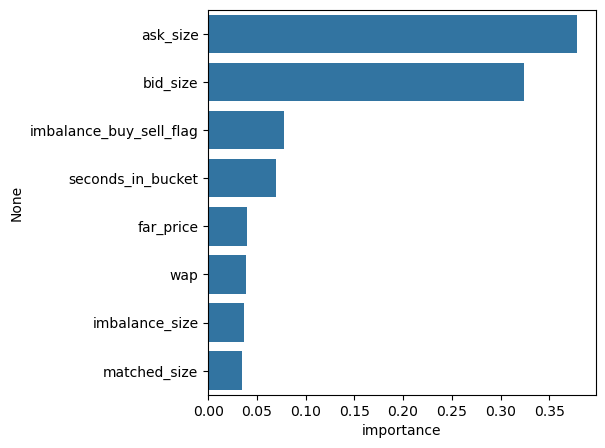

In [190]:
fig, ax = plt.subplots(figsize=(5, 5))
sns.barplot(data=df_feature_importance, 
            y=df_feature_importance.index, 
            x='importance', 
            orient='h', 
            ax=ax)

ax.set_ylabel('Feature')
ax.set_xlabel('Feature Importance')

In [222]:
# Save model
# import pickle
# with open('xgboost_best.pkl', 'wb') as file:
#     pickle.dump(grid_search.best_estimator_, file)

In [145]:
data = pd.DataFrame({
    'timestamp': pd.date_range(start='2024-12-01', periods=10, freq='D'),
    'value': range(10)
})

# Resample to weekly frequency and compute mean
data.set_index('timestamp', inplace=True)
resampled = data.resample('W').mean()
print(resampled)

            value
timestamp        
2024-12-01    0.0
2024-12-08    4.0
2024-12-15    8.5


In [168]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Example data (must have a datetime index)
result = seasonal_decompose(data['value'], model='additive', period=7)
result.plot()

KeyError: 'value'

In [153]:
data.head()

,stock_id,date_id,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target,time_id,row_id
seconds_in_bucket,,,,,,,,,,,,,,,,
0,0,0,3180602.69,1,0.999812,13380276.64,0.0,0.0,0.999812,60651.50,1.000026,8493.03,1.000000,-3.029704,0,0_0_0
10,0,0,1299772.70,1,1.000026,15261106.63,0.0,0.0,0.999812,13996.50,1.000026,23519.16,0.999892,0.389814,1,0_10_0
20,0,0,1299772.70,1,0.999919,15261106.63,0.0,0.0,0.999812,4665.50,0.999919,12131.60,0.999842,4.220009,2,0_20_0
30,0,0,1299772.70,1,1.000133,15261106.63,0.0,0.0,1.000026,55998.00,1.000133,46203.30,1.000085,5.450249,3,0_30_0
40,0,0,1218204.43,1,1.000455,15342674.90,0.0,0.0,1.000241,14655.95,1.000455,26610.45,1.000317,3.169775,4,0_40_0


In [169]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Example data (must have a datetime index)
data = df_cleaned.query('stock_id == 0 and date_id == 0').set_index('seconds_in_bucket')
result = seasonal_decompose(data['target'], model='additive', period=7)

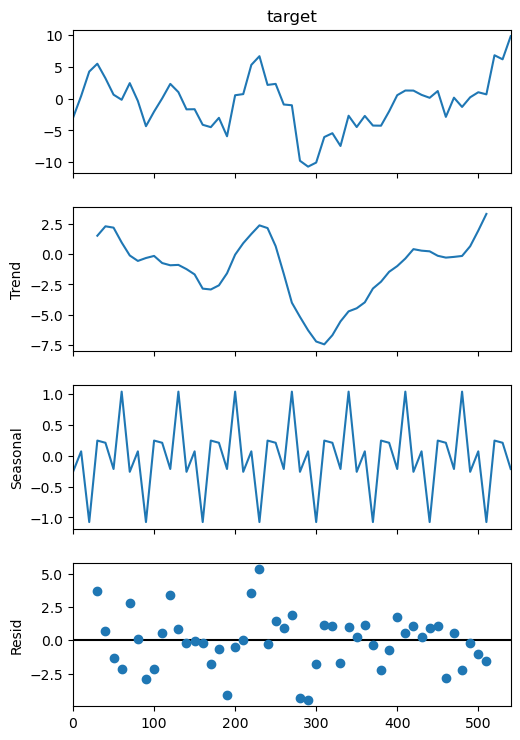

In [174]:
fig = result.plot()
fig.set_size_inches(5, 8)

In [175]:
from statsmodels.tsa.stattools import adfuller

In [177]:
dftest = adfuller(data['target'])
dfoutput=pd.Series(dftest[0:4],index=['Test statistic','p-value','#Lags Used','Number of Obervations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value(%s)'%key]=value
print(dfoutput)


Test statistic                -1.360039
p-value                        0.601277
#Lags Used                     6.000000
Number of Obervations Used    48.000000
Critical Value(1%)            -3.574589
Critical Value(5%)            -2.923954
Critical Value(10%)           -2.600039
dtype: float64


In [187]:
import scipy.stats as stats

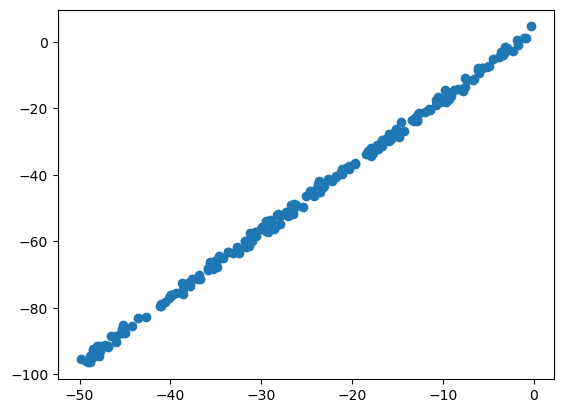

In [193]:
x = stats.uniform.rvs(-50, 50, 200)
y = 2 * x + 3 + stats.norm.rvs(0, 1, 200)
plt.scatter(x, y)

In [194]:
import statsmodels.api as sm

In [201]:
x_addconst = sm.add_constant(x)
model = sm.OLS(y, x_addconst).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.999
Model:                            OLS   Adj. R-squared:                  0.999
Method:                 Least Squares   F-statistic:                 1.523e+05
Date:                Fri, 20 Dec 2024   Prob (F-statistic):          9.85e-288
Time:                        11:31:58   Log-Likelihood:                -285.26
No. Observations:                 200   AIC:                             574.5
Df Residuals:                     198   BIC:                             581.1
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.0602      0.149     20.555      0.000       2.767       3.354
x1             1.9963      0.005    390.195      0.000       1.986       2.006
==============================================================================
Omnibus:                        5.941   Durbin-Watson:                   2.083
Prob(Omnibus):                  0.051   Jarque-Bera (JB):                3.319
Skew:                          -0.059   Prob(JB):                        0.190
Kurtosis:                       2.380   Cond. No.                         60.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [202]:
model = sm.OLS(y, x).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.999
Model:                            OLS   Adj. R-squared (uncentered):              0.999
Method:                 Least Squares   F-statistic:                          1.921e+05
Date:                Fri, 20 Dec 2024   Prob (F-statistic):                   5.42e-299
Time:                        11:35:40   Log-Likelihood:                         -399.49
No. Observations:                 200   AIC:                                      801.0
Df Residuals:                     199   BIC:                                      804.3
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.9041      0.004    438.282      0.000       1.895       1.913
==============================================================================
Omnibus:                        0.890   Durbin-Watson:                   1.728
Prob(Omnibus):                  0.641   Jarque-Bera (JB):                0.920
Skew:                          -0.001   Prob(JB):                        0.631
Kurtosis:                       2.668   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [206]:
def inspect_columns_1(df):
    return pd.DataFrame({
        'length': len(df),
        'cardinality': df.nunique(),
        'uniqueness': df.nunique() == len(df),
        'null_cnt': df.isnull().sum(),
        'null_pct': df.isnull().sum()/len(df),
        '1st_row': df.iloc[0],
        'random_row': df.iloc[random.randint(0, len(df))],
        'last_row': df.iloc[-1],
        'type': df.dtypes
    })

In [208]:
inspect_columns_1(df)

,length,cardinality,uniqueness,null_cnt,null_pct,1st_row,random_row,last_row,type
stock_id,5237980,200,False,0,0.000000,0,96,199,int64
date_id,5237980,481,False,0,0.000000,0,161,480,int64
seconds_in_bucket,5237980,55,False,0,0.000000,0,410,540,int64
imbalance_size,5237980,2971863,False,220,0.000042,3180602.69,1787699.5,1884285.71,float64
imbalance_buy_sell_flag,5237980,3,False,0,0.000000,1,-1,-1,int64
reference_price,5237980,28741,False,220,0.000042,0.999812,0.997462,1.002129,float64
matched_size,5237980,2948862,False,220,0.000042,13380276.64,49281375.63,24073677.32,float64
far_price,5237980,95739,False,2894342,0.552568,NaN,0.992697,1.000859,float64
near_price,5237980,84625,False,2857180,0.545474,NaN,0.995874,1.001494,float64
bid_price,5237980,28313,False,220,0.000042,0.999812,0.997317,1.002129,float64
